# CSE 152A Fall 2022 – Assignment 2


- Assignment Published On: **Mon, Oct 17, 2022**

- Due On: **Sat, Oct 29, 2022 11:59 PM (Pacific Time)**



In [1]:
# Setup
import numpy as np
from time import time
from skimage import io
%matplotlib inline
import matplotlib.pyplot as plt

## Problem 1: Edge & Cornder Detection [23 pts]

### Problem 1.1: Edge Detection [8 pts]

In this problem, you will write a function to perform edge detection. The following steps need to be implemented.

- **Smoothing [2 pt]:** First, we need to smooth the images to prevent noise from being considered edges. For this problem, use a 9x9 Gaussian kernel filter with $\sigma = 1.4$ to smooth the images.

- **Gradient Computation [3+3 pts]:** After you have finished smoothing, find the image gradient in the horizontal and vertical directions. Compute the gradient magnitude image as $|G| = \sqrt{G_x^2 + G_y^2}$  and gradient direction as $tan^{-1}(G_y/G_x)$.

Compute the images after each step. Show each of the intermediate steps and label your images accordingly.

In total, there should be four output images (original, smoothed, gradient magnitude, gradient direction).

**For this question, use the image `geisel.jpeg`.**

Original:


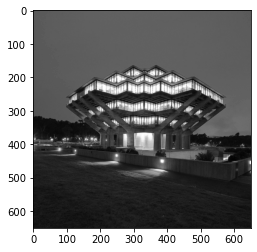

Smoothed:


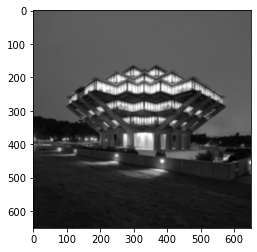

Gradient magnitude:


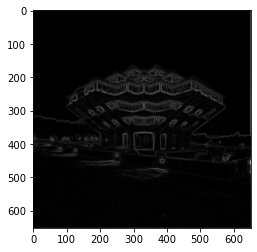

Gradient direction:


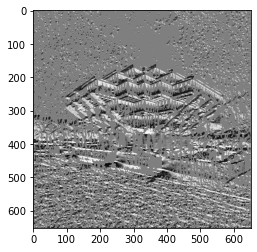

In [2]:
import numpy as np
import scipy
from skimage import io
from collections import defaultdict
from scipy.signal import convolve
import matplotlib.pyplot as plt
%matplotlib inline

def gaussian2d(filter_size=9, sig=1.0):
    """
    Creates 2D Gaussian kernel with side length `filter_size` and a sigma of `sig`.
    Source: https://stackoverflow.com/a/43346070
    """
    ax = np.arange(-filter_size // 2 + 1., filter_size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))
    return kernel / np.sum(kernel)


def smooth(image):
    smooth_image = np.zeros_like(image)
    
    ### YOUR CODE HERE
    
    # Create the kernel filter 
    kernel = gaussian2d(filter_size=9, sig=1.4)
    # Compute the convolution
    smooth_image = scipy.ndimage.convolve(image,kernel)

    ### END YOUR CODE
    
    return smooth_image

def gradient(image):

    g_mag = np.zeros_like(image)
    g_theta = np.zeros_like(image)
    
    ### YOUR CODE HERE
    
    # Define the filters to compute the gradient
    
    # Filter for dx
    f = np.array([[-1,0,+1],
                  [-2,0,+2],
                  [-1,0,+1]])
    # Filter for dy
    g = np.array([[1,2,1],
                  [0,0,0],
                  [-1,-2,-1]])
    
    # Convolve the image and the filters to obtain derivatives
    dx = convolve(f,image)
    dy = convolve(g,image)
    
    # Compute the gradient magnitude (edge strength)
    g_mag = np.sqrt((dx**2)+(dy**2))
    
    # Compute the gradient direction
    g_theta = np.arctan(np.divide(dy,dx, where = (dx>0)))
                
    ### END YOUR CODE
     
    return g_mag, g_theta

def edge_detect(image):
    """Perform edge detection on the image."""
    smoothed = smooth(image)
    g_mag, g_theta = gradient(smoothed)
    return smoothed, g_mag, g_theta

# Load image in grayscale
image = io.imread('geisel.jpeg', as_gray=True)
smoothed, g_mag, g_theta = edge_detect(image)

print('Original:')
plt.imshow(image, cmap='gray')
plt.show()

print('Smoothed:')
plt.imshow(smoothed, cmap='gray')
plt.show()

print('Gradient magnitude:')
plt.imshow(g_mag, cmap='gray')
plt.show()

print('Gradient direction:')
plt.imshow(g_theta, cmap='gray')
plt.show()

### Problem 1.2: Corner Detection [15 pts]

Next, you will implement a corner detector to detect photo-identifiable features in the image.

This should be done according to the easier method of looking at regions with significant value of the minimum eigenvalue. You should fill in the function <code>corner_detect</code> with inputs <code>image, nCorners, smoothSTD, windowSize</code>, where smoothSTD is the standard deviation of the smoothing kernel and windowSize is the window size for Gaussian smoothing, corner detection and non-maximum suppression. Instead of using a hard threshold, return the nCorners strongest corners after non-maximum suppression. This way you can control exactly how many corners are returned. Your function should also return the matrix of minimum eigen values that you computed.

For each image, detect 100 corners with a Gaussian standard deviation of 2.0 and a window size of 13. Display the corners using the show_corners_result function and plot the minimum eigen value images using the show_eigen_images function.

**For this question, we will use images `almond0.jpg` and `almond1.jpg`.**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [4]:
def rgb2gray(rgb):
    """ Convert rgb image to grayscale.
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [5]:
def corner_detect(image, nCorners, smoothSTD, windowSize):
    """Detect corners on a given image.

    Args:
        image: Given a grayscale image on which to detect corners.
        nCorners: Total number of corners to be extracted.
        smoothSTD: Standard deviation of the Gaussian smoothing kernel.
        windowSize: Window size for Gaussian smoothing kernel, corner detector, and non maximum suppression.

    Returns:
        Detected corners (in image coordinate) in a numpy array (n*2).
        The minor eigen value image having the same shape as the image
    """
    

    corners = np.zeros((nCorners, 2))
    minor_eig_image = np.zeros_like(image)

    ### YOUR CODE
    
    # First, we need to create the gaussian filter 
    gaussian_filter = gaussian2d(windowSize, smoothSTD)
    
    # Apply the filter to smooth the image
    smooth_image = scipy.ndimage.convolve(image,gaussian_filter)
    
    # Define the filters to compute the gradient
    
    # Filter for dx
    f = np.array([[-1,0,+1],
                  [-2,0,+2],
                  [-1,0,+1]])
    # Filter for dy
    g = np.array([[1,2,1],
                  [0,0,0],
                  [-1,-2,-1]])
    
    # Convolve the image and the filters to obtain derivatives
    dx = convolve(f,image)
    dy = convolve(g,image)
    
    # Compute the components of matrix C (corner)
    dx2 = dx * dx
    dy2 = dy * dy
    dxy = dx * dy
    
    # Apply the window at every pixel by using the convolution
    Ix2 = scipy.ndimage.convolve(dx2,gaussian_filter)
    Iy2 = scipy.ndimage.convolve(dy2,gaussian_filter)
    Ixy = scipy.ndimage.convolve(dxy,gaussian_filter)
    
    # Create an array to store all the minor eigenvalues (matrix R)
    minor_eig_image = np.zeros_like(image)
    
    aux = int(windowSize//2)
    
    # Compute all second-moment matrices given the window size
    # I will start from point (6,6) to avoid exceding the bounds of the image
    
    for x in range(aux,np.shape(image)[0]-aux):
        for y in range(aux,np.shape(image)[1]-aux):
        
            # Compute the matrix C at pixel x,y
            corner = np.array([[Ix2[x, y], Ixy[x, y]], 
                          [Ixy[x, y], Iy2[x, y]]])
            
            # Store the minimal eigenvalue corresponding to the corner at pixel x,y
            minor_eig_image[x, y] = np.linalg.det(corner) - 0.04 * (np.power(np.trace(corner), 2))
    
    all_corners = np.array([(0,0)])
    all_corners_eig = np.array([0])
    
    # Iterate through the eigenvalue matrix to find the corners
    for x in range(aux, image.shape[0]-aux):
        for y in range(aux, image.shape[1]-aux):
            
            # Obtain the local maximum for each window (Non-Maximum Suppression)
            # Store the window
            window = minor_eig_image[x-aux:x+aux+1, y-aux:y+aux+1]
            # Check if the maximum value in thw window corresponds to the center
            # If it is the case, we store the coordinates since it is a possible corner
            if window[aux][aux] == np.max(window):
                all_corners_eig = np.row_stack((all_corners_eig, [minor_eig_image[x,y]]))
                all_corners = np.row_stack((all_corners, [y, x]))
            
    # From the possible corners, select n with the highest eigenvalues 
    # Identify the n-th highest eigenvalue 
    nth_eig = np.unique(all_corners_eig)[::-1][nCorners]
    # Store the n corners indexes 
    idx_nCorners, _ = np.where(all_corners_eig > nth_eig)
    # Store the corners
    corners = all_corners[idx_nCorners]
    
    return corners, minor_eig_image

In [6]:
def show_eigen_images(imgs):
    print("Minor Eigen value images")
    fig = plt.figure(figsize=(16, 16))
    # Plot image 1
    plt.subplot(1,2,1)
    plt.imshow(imgs[0], cmap='gray')
    plt.title('almond 1')

    # Plot image 2
    plt.subplot(1,2,2)
    plt.imshow(imgs[1], cmap='gray')
    plt.title('almond 2')
    
    plt.show()
    
def show_corners_result(imgs, corners):
    print("Detected Corners")
    fig = plt.figure(figsize=(16, 16))
    ax1 = fig.add_subplot(221)
    ax1.imshow(imgs[0], cmap='gray')
    ax1.scatter(corners[0][:, 0], corners[0][:, 1], s=35, edgecolors='r', facecolors='none')

    ax2 = fig.add_subplot(222)
    ax2.imshow(imgs[1], cmap='gray')
    ax2.scatter(corners[1][:, 0], corners[1][:, 1], s=35, edgecolors='r', facecolors='none')
    plt.show()

In [7]:
# detect corners on the two provided images
# adjust your corner detection parameters here
nCorners = 100
smoothSTD = 2
windowSize = 13

# read images and detect corners on images
imgs = []
eig_imgs = []
corners = []
for i in range(2):
    img = io.imread('almond' + str(i) + '.jpg')
    imgs.append(rgb2gray(img))
    corners_vals, minor_eig_image = corner_detect(imgs[-1], nCorners, smoothSTD, windowSize)
    eig_imgs.append(minor_eig_image)
    corners.append(corners_vals)

Minor Eigen value images


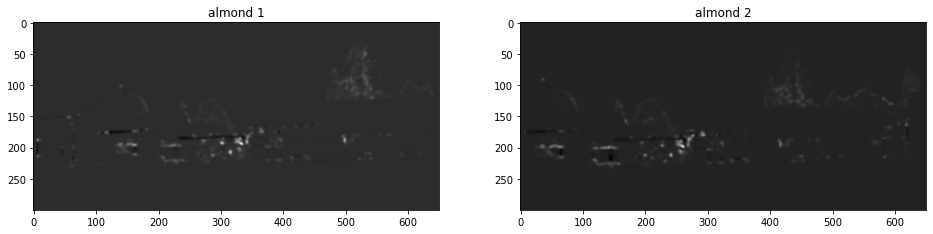

Detected Corners


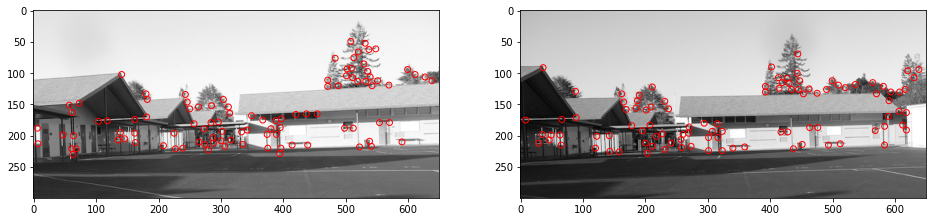

In [8]:
show_eigen_images(eig_imgs)
show_corners_result(imgs, corners)

## Problem 2: Theory [20 points]
### Problem 2.1: Epipolar Geometry [10 points]

Consider two cameras whose image planes are the z=2 plane, and whose focal points are at (-6, 0, 0) and (6, 0, 0). See Fig 1.1 below. We'll call a point in the first camera (x, y), and a point in the second camera (u, v). Points in each camera are relative to the camera center. So, for example if (x, y) = (0, 0), this is really the point (-6, 0, 2) in world coordinates, while if (u, v) = (0, 0) this is the point (6, 0, 2).

![fig 1.1](fig/fig1.png)

Suppose the point (x, y) = (3, 3) is matched to the point (u, v) = (2, 3). What is the 3D location of this point?

First, we need to transform the camera points into world coordinates:

$(x,y) = (3,3)$ corresponds to $(-3,3,2)$ and
$(u,v) = (2,3)$ corresponds to $(8,3,2)$

Now, using these points we can define the lines going through them and their respective camera focal point:

$$ l_1 = (-6,0,0) + (3,3,2)*t $$
$$ l_2 = (6,0,0) + (2,3,2)*u $$

Finally, the 3D point we want to obatin is the intersection of these two lines. If we equal both lines, we obtain the following system of equations:

$$ -6 + 3t = 6 + 2u $$
$$ 3t = 3u $$
$$ 2u = 2u $$

If we solve this system, we obtain that: $$ t = u = 12 $$

And hence the 3D point corresponds to:

$$ X = (30,36,24) $$

### Problem 2.2: The Epipolar Constraint [5 points]

Suppose two cameras fixate on a point $P$ in space such that their principal axes intersect at that point. (See the fig. 1.2 below.) Show that if the image coordinates are normalized so that the coordinate origin (0, 0) coincides with the principal point, then the $F_{33}$ element of the fundamental matrix is zero.

![fig 1.2](fig/ec_diagram.png)

In the figure, $C1$ and $C2$ are the optical centers. The principal axes intersect at point $P$.

We know from the lectures that for any two corresponding points x and y in the two images, the following constraint must be fulfilled:

$$ x^TFy = y^TFx = 0 $$

In this case, we have:

$$ (0,0,1)F(0,0,1)^T = 0 $$

If we develop this expression, we obtain:

$$ (F_{13},F_{23},F_{33})(0,0,1)^T = 0 $$ 

which implies:

$$ F_{33} = 0 $$ as we wanted to prove.

### Problem 2.3: Essential Matrix [5 points]

Suppose a stereo rig is formed of two cameras: the rotation matrix and translation vector are given to you. Please write down the essential matrix. Also, compute the rank of the essential matrix using SVD, i.e., the number of nonzero singular values. (Note that if you get a singular value $s$ of a very small number in your calculation, e.g., $s<=1e-15$, you can treat it as zero singular value). 


$$ R=
\begin{bmatrix}
\frac{\sqrt{2}}{2} & -\frac{\sqrt{2}}{2} & 0 \\
\frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2} & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

$$ t=
\begin{bmatrix}
2 \\ 5 \\1
\end{bmatrix}
$$


In [9]:
# Store matrix R
R = np.array([[np.sqrt(2)/2,-np.sqrt(2)/2,0],
            [np.sqrt(2)/2,np.sqrt(2)/2,0],
            [0,0,1]])
# Store vector t
t = np.array([2,5,1])
# Compute and print essential matrix
E = np.cross(t,R)
print("Essential matrix: \n")
print(E)

Essential matrix: 

[[ 0.70710678  0.70710678 -4.94974747]
 [-0.70710678  0.70710678 -2.12132034]
 [ 5.         -2.          0.        ]]


In [10]:
# Compute Singular Value Decomposition (SVD) of the essential matrix
# I will be storing only the main diagonal of the diagonal matrix D.
_, D, _ = np.linalg.svd(E, full_matrices=False)
# Check the singular values to identify the rank
print(D)

[5.47722558e+00 5.47722558e+00 7.03707923e-17]


Since the value $ 7.03 * 10^{-17} ≈ 0 $, we have two non-zero singular values. This implies:

$$ Rank (E) = 2 $$

## Problem 3: SSD (Sum Squared Distance) and NCC (Normalized Cross-Correlation) Matching [21 points]
In this part, you have to write two functions <code>ssdMatch</code> and <code>nccMatch</code> that implement the computation of the matching score for two given windows with SSD and NCC metrics respectively.

### Problem 3.1: SSD (Sum Squared Distance) Matching [5 points]
Complete the function <code>ssdMatch</code>:  
SSD = $\sum_{x,y}|W_1(x,y)-W_2(x,y)|^2$

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import imageio
import pickle

In [2]:
def ssdMatch(img1, img2, c1, c2, R):
    """Compute SSD given two windows.
    
    Args:
        img1: Image 1.
        img2: Image 2.
        c1: Center (in image coordinate) of the window in image 1.
        c2: Center (in image coordinate) of the window in image 2.
        R: R is the radius of the patch, 2 * R + 1 is the window size

    Returns:
        SSD matching score for two input windows.
        
    """
    """ ==========
    YOUR CODE HERE
    ========== """
    
    # Create the matching_score variable
    matching_score = 0
    # Iterate through both windows to add the score
    # The limits of the window are obtained by adding or substracting the radius to the center
    for x in range(-R, R + 1):
        for y in range(-R, R + 1):
            # Window image 1
            w1 = img1[c1[1] + x, c1[0] + y]
            # Window image 2
            w2 = img2[c2[1] + x, c2[0] + y]
            # Add the matching score
            matching_score += (w1 - w2)**2

    return matching_score

In [3]:
# Here is the code for you to test your implementation
img1 = np.array([[1, 2, 3, 4], [4, 5, 6, 8], [7, 8, 9, 4]])
img2 = np.array([[1, 2, 1, 3], [6, 5, 4, 4], [9, 8, 7, 3]])
print(ssdMatch(img1, img2, np.array([1, 1]), np.array([1, 1]), 1))
# should print 20
print(ssdMatch(img1, img2, np.array([2, 1]), np.array([2, 1]), 1))
# should print 30
print(ssdMatch(img1, img2, np.array([1, 1]), np.array([2, 1]), 1))
# should print 46

20
30
46


### Problem 3.2: NCC (Normalized Cross-Correlation) Matching [8 points]
Complete the function <code>nccMatch</code>:
NCC = $\sum_{x,y}\tilde{W_1} (x,y)\cdot \tilde{W_2} (x,y)$ where $\tilde{W} = \frac{W - \overline{W}}{\sqrt{\sum_{x,y}(W(x,y) - \overline{W})^2}}$ is a mean-shifted and normalized version of the window and $\overline{W}$ is the mean pixel value in the window W.

In [4]:
def nccMatch(img1, img2, c1, c2, R):
    """Compute NCC given two windows.

    Args:
        img1: Image 1.
        img2: Image 2.
        c1: Center (in image coordinate) of the window in image 1.
        c2: Center (in image coordinate) of the window in image 2.
        R: R is the radius of the patch, 2 * R + 1 is the window size

    Returns:
        NCC matching score for two input windows.

    """
    
    """ ==========
    YOUR CODE HERE
    ========== """
    
    # Create the matching_score variable
    matching_score = 0
    
    # Store the window images
    m1 = img1[c1[1] - R:c1[1] + R + 1, c1[0] - R:c1[0] + R + 1]
    m2 = img2[c2[1] - R:c2[1] + R + 1, c2[0] - R:c2[0] + R + 1]
    
    # Compute the mean and standard deviation of each image window
    mean_img1 = np.mean(m1)
    mean_img2 = np.mean(m2)
    sigma_img1 = np.std(m1, dtype = np.float64)
    sigma_img2 = np.std(m2, dtype = np.float64)
    
    # Iterate through both windows to add the mean-shifted and normalized score
    for x in range(-R, R + 1):
        for y in range(-R, R + 1):
            # Window image 1
            w1 = img1[c1[1] + x, c1[0] + y]
            # Window image 2
            w2 = img2[c2[1] + x, c2[0] + y]
            # Normalize
            # We need to multiply the denominator by np.sqrt(n), since the expression
            # corresponds to the Standard Deviation without including 1/sqrt(n)
            w1_norm = (w1 - mean_img1)/(sigma_img1  * np.sqrt(m1.shape[0] * m1.shape[1]))
            w2_norm = (w2 - mean_img2)/(sigma_img2  * np.sqrt(m2.shape[0] * m2.shape[1]))
            # Add the matching score
            matching_score += (w1_norm * w2_norm)

    return matching_score

In [5]:
# Here is the code for you to test your implementation
img1 = np.array([[1, 2, 3, 4], [4, 5, 6, 8], [7, 8, 9, 4]])
img2 = np.array([[1, 2, 1, 3], [6, 5, 4, 4], [9, 8, 7, 3]])
print(nccMatch(img1, img2, np.array([1, 1]), np.array([1, 1]), 1))
# should print 0.8546
print(nccMatch(img1, img2, np.array([2, 1]), np.array([2, 1]), 1))
# should print 0.8457
print(nccMatch(img1, img2, np.array([1, 1]), np.array([2, 1]), 1))
# should print 0.6258

0.8546547739343037
0.845761528217442
0.6258689611426175



### Problem 3.3: Naive Matching [8 points]

Given the corner points detected and the NCC matching function, we are ready to start finding correspondences. One naive strategy is to try and find the best match between the two sets of corner points. Write a script that does this, namely, for each corner in image1, find the best match from the detected corners in image2 (or, if the NCC match score is too low, then return no match for that point). 

Write a function <code>naive_matching</code> and call it as below. Examine your results for 20 detected corners in each image. 


In [14]:
def naive_matching(img1, img2, corners1, corners2, R, NCCth):
    """Compute NCC given two windows.

    Args:
        img1: Image 1.
        img2: Image 2.
        corners1: Corners in image 1 (nx2)
        corners2: Corners in image 2 (nx2)
        R: NCC matching radius
        NCCth: NCC matching score threshold

    Returns:
        NCC matching result a list of tuple (c1, c2), 
        c1 is the 1x2 corner location in image 1, 
        c2 is the 1x2 corner location in image 2. 

    """
    
    """ ==========
    YOUR CODE HERE
    ========== """
    
    # Create and array (matrix) which contains the matching value between two points
    m = corners1.shape[0]
    n = corners2.shape[0]
    ncc_matrix = np.zeros((m,n))
    
    # Compute the matching value between every pair of points
    for x in range(m):
        for y in range(n):
            # Store the matching value in the matrix
            ncc_matrix [x,y] = nccMatch(img1, img2, corners1[x], corners2[y], R)
    
    # Define matching array
    matching = []
    
    # Check whether the ncc value is above the threshold or not
    for i in range(m):
        # Every point must be matched only once
        max_match = 0
        # Iterate until we obtain the best match
        for j in range(n):
            if ncc_matrix[i,j] > max_match:
                corner2_match = corners2[j]
                max_match = ncc_matrix[i,j]
        # Check the threshold
        if max_match > NCCth:
            # Store the corresponding match as a tuple
            matching.append((corners1[i],corner2_match))
               
    return matching

In [15]:
def rgb2gray(rgb):
    """ Convert rgb image to grayscale.
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
# detect corners on warrior and matrix sets
# you are free to modify code here, create your helper functions, etc.

nCorners = 20  
smoothSTD = 1
windowSize = 17

# read images and detect corners on images

imgs_mat = []
crns_mat = []
imgs_war = []
crns_war = []

for i in range(2):
    img_mat = imageio.imread('p4/matrix/matrix' + str(i) + '.png')
    imgs_mat.append(rgb2gray(img_mat))
    img_war = imageio.imread('p4/warrior/warrior' + str(i) + '.png')
    imgs_war.append(rgb2gray(img_war))

In [22]:
# match corners
crnsmatf=open('crns_mat.pkl','rb')
crns_mat=pickle.load(crnsmatf)
crnswarf=open('crns_mat.pkl','rb')
crns_war=pickle.load(crnswarf)
R = 120
NCCth = 0.6  # put your threshold here
matching_mat = naive_matching(imgs_mat[0]/255, imgs_mat[1]/255, crns_mat[0], crns_mat[1], R, NCCth)
matching_war = naive_matching(imgs_war[0]/255, imgs_war[1]/255, crns_war[0], crns_war[1], R, NCCth)

Number of Corners: 20


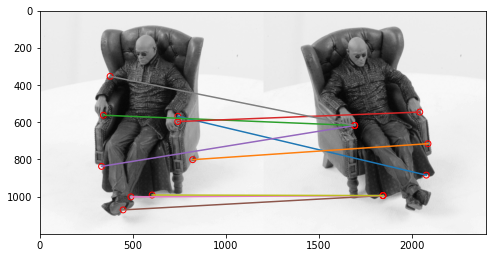

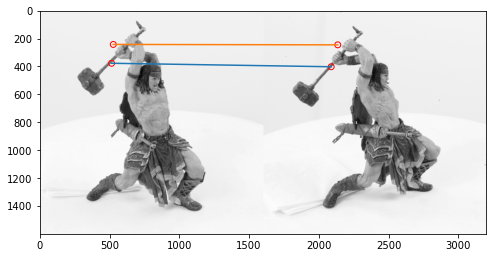

In [23]:
# plot matching result
def show_matching_result(img1, img2, matching):
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(np.hstack((img1, img2)), cmap='gray') # two dino images are of different sizes, resize one before use
    for p1, p2 in matching:
        plt.scatter(p1[0], p1[1], s=35, edgecolors='r', facecolors='none')
        plt.scatter(p2[0] + img1.shape[1], p2[1], s=35, edgecolors='r', facecolors='none')
        plt.plot([p1[0], p2[0] + img1.shape[1]], [p1[1], p2[1]])
    plt.savefig('dino_matching.png')
    plt.show()

print("Number of Corners:", nCorners)
show_matching_result(imgs_mat[0], imgs_mat[1], matching_mat)
show_matching_result(imgs_war[0], imgs_war[1], matching_war)

## Problem 4: Epipolar Geometry [34 points]

As shown in Problem 2, the naive mathing algorithm is simple. The weakness of this method comes from the high matching complexity. In this problem, we will explore how to visualize epipolar geometry constraint in the form of epipolar lines. Although it is outside the scope of this assignment, we can further use this constraint to rectify the images to build a better matching algorithm.

### Problem 4.1: Fundamental matrix [10 points]
Complete the <code>compute_fundamental</code> function below using the 8-point algorithm described in lecture. Note that the normalization of the corner points is handled in the <code>fundamental_matrix</code> function. <br/>
Hint: When you try to find the non-trival solution to an linear equation system **Af=0**, you can use singular value decomposition (SVD) method:SVD(__A__)=USV<sup>T</sup>. And **f** is given by the singular vector corresponding to the smallest singular value, which is the last column of V.

In [225]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from scipy.io import loadmat
from numpy.linalg import svd

def compute_fundamental(x1, x2):
    """ Computes the fundamental matrix from corresponding points 
        (x1,x2 3*n arrays) using the 8 point algorithm.
        
        Construct the A matrix according to lecture
        and solve the system of equations for the entries of the fundamental matrix.

        Returns:
        Fundamental Matrix (3x3)
    """
    
    """ ==========
    YOUR CODE HERE
    ========== """
    
    x1, x2 = x2, x1
    
    # Store the number of points
    n_points = np.shape(x1)[1]
    
    # Create the contraint matrix 
    A = np.ones((n_points,9))
    
    # Fill the matrix with all the constraints 
    for row in range(n_points):
        A[row] = ([x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i]*x2[2,i],
                x1[1,i]*x2[0,i], x1[1,i]*x2[1,i], x1[1,i]*x2[2,i],
                x1[2,i]*x2[0,i], x1[2,i]*x2[1,i], x1[2,i]*x2[2,i]])

    # Compute Singular Value Decomposition
    # The fundamental matrix is obtained from the column V (lowest singular value)
    _,_,V = np.linalg.svd(A)

    # Create matrix F by reshaping
    F = np.reshape(V[-1],(3,3))
    
    # constrain F
    # make rank 2 by zeroing out last singular value
    U,S,V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U,np.dot(np.diag(S),V))
    
    return F/F[2,2]

In [226]:
def fundamental_matrix(x1,x2):
    # Normalization of the corner points is handled here
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    # normalize image coordinates
    x1 = x1 / x1[2]
    mean_1 = np.mean(x1[:2],axis=1)
    S1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([[S1,0,-S1*mean_1[0]],[0,S1,-S1*mean_1[1]],[0,0,1]])
    x1 = np.dot(T1,x1)
    
    x2 = x2 / x2[2]
    mean_2 = np.mean(x2[:2],axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([[S2,0,-S2*mean_2[0]],[0,S2,-S2*mean_2[1]],[0,0,1]])
    x2 = np.dot(T2,x2)

    # compute F with the normalized coordinates
    F = compute_fundamental(x1,x2)

    # reverse normalization
    F = np.dot(T1.T,np.dot(F,T2))

    return F/F[2,2]

In [227]:
# Here is the code for you to test your implementation
cor1 = np.load("./p4/"+'dino'+"/cor1.npy")
cor2 = np.load("./p4/"+'dino'+"/cor2.npy")
print(fundamental_matrix(cor1,cor2))
# should print 
#[[ 4.00502510e-07  3.09619039e-06 -2.86966053e-03]
#[-2.69900666e-06 -1.00972419e-08  6.70452915e-03]
#[ 1.37819769e-03 -7.29675791e-03  1.00000000e+00]]

[[-4.02848861e-07 -1.11640910e-07  9.56754389e-05]
 [-6.34466994e-07 -5.85081162e-08  7.32232780e-04]
 [-8.82722988e-04 -8.51824859e-05  1.00000000e+00]]


### Problem 4.2: Epipoles [8 points]
In this part, you are supposed to complete the function <code>compute_epipole</code> to calculate the epipoles for a given fundamental matrix.

In [228]:
def compute_epipole(F):
    """
    This function computes the epipoles for a given fundamental matrix.
    
    input:
      F --> fundamental matrix
    output:
      e1 --> corresponding epipole in image 1
      e2 --> epipole in image2
    """

    """ ==========
    YOUR CODE HERE
    ========== """
    
    # Since an epipole is given by e = null(F), we can compute SVD to obtain both epipoles
    # Notice both fullfill F.T*e1 = 0 and F*e2 = 0
    
    # SVD (e1)
    _,_,V1 = np.linalg.svd(F.T)
    
    # SVD (e2)
    _,_,V2 = np.linalg.svd(F)
    
    # Compute the epipoles
    e1 = V1[2]/V1[2,2]
    e2 = V2[2]/V2[2,2]

    return e1,e2

In [229]:
# Here is the code for you to test your implementation
F_test = np.array([[1, 2, 1], [6, 5, 4], [9, 8, 1]])
print(compute_epipole(F_test))
# should print 
#(array([-65.3659783 ,  15.85984739,   1.        ]), 
#array([-41.86658577,  46.87378417,   1.        ]))

(array([-65.3659783 ,  15.85984739,   1.        ]), array([-41.86658577,  46.87378417,   1.        ]))


### Problem 4.3: Plot Epipolar Lines [16 points]

Using this fundamental matrix, plot the epipolar lines in both images for each image pair. For this part, you will want to complete the function <code>plot_epipolar_lines</code>. Show your result for matrix and warrior as exemplified by the figure below. 

![Dino Epipolar](fig/dinoEpi1.png)
![Dino Epipolar](fig/dinoEpi2.png)



In [230]:
def plot_epipolar_lines(img1, img2, cor1, cor2):
    """Plot epipolar lines on image given image, corners

    Args:
        img1: Image 1.
        img2: Image 2.
        cor1: Corners in homogeneous image coordinate in image 1 (3xn)
        cor2: Corners in homogeneous image coordinate in image 2 (3xn)

    """
    
    
    assert cor1.shape[0] == 3
    assert cor2.shape[0] == 3
    assert cor1.shape == cor2.shape
    
    F = fundamental_matrix(cor1, cor2)
    e1, e2 = compute_epipole(F)

    """ ==========
    YOUR CODE HERE
    ========== """
    
    # Number of corners in each image
    n_corners = np.shape(cor1)[1]

    # Plot corners and epipolar lines for image 1
    for i in range(n_corners):
        # Corners
        plt.plot(cor1[0,i], cor1[1,i], marker = "o", color = "red")
        # Epipolar lines
        plt.plot([cor1[0,i],e1[0]], [cor1[1,i],e1[1]], linewidth = 1, color = "red")
    
    # Plot the image
    plt.imshow(img1)
    plt.show()
    
    # Plot corners and epipolar lines for image 2
    for j in range(n_corners):
        # Corners
        plt.plot(cor2[0,j], cor2[1,j], marker = "o", color = "blue")
        # Epipolar lines
        plt.plot([cor2[0,j],e2[0]], [cor2[1,j],e2[1]], linewidth = 1, color = "blue")
    
    # Plot the image
    plt.imshow(img2)
    plt.show()
    

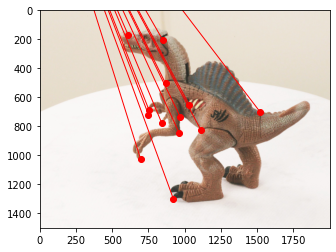

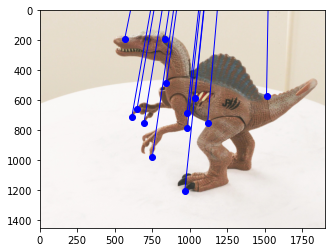

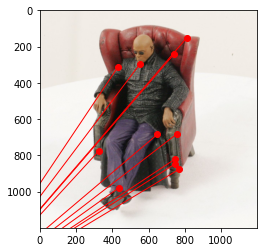

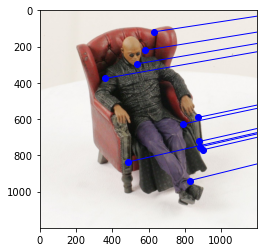

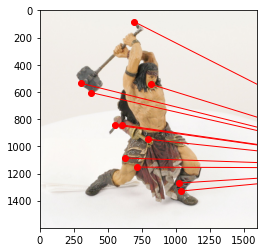

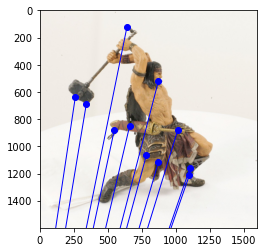

In [231]:
# replace images and corners with those of matrix and warrior
imgids = ["dino", "matrix", "warrior"]
for imgid in imgids:
    I1 = imageio.imread("./p4/"+imgid+"/"+imgid+"0.png")
    I2 = imageio.imread("./p4/"+imgid+"/"+imgid+"1.png")
    cor1 = np.load("./p4/"+imgid+"/cor1.npy")
    cor2 = np.load("./p4/"+imgid+"/cor2.npy")
    plot_epipolar_lines(I1,I2,cor1,cor2)
